## Data Import

In [1]:
import pandas as pd

In [2]:
# My path to file is different than some people, so this will have to change depending on who's running it
df_bb = pd.read_csv('/content/imdb_barbie_Uncleaned.csv', header=None)
df_op = pd.read_csv('/content/imdb_oppenhimmer_Uncleaned.csv', header=None)
df_bb.drop_duplicates(inplace=True)
df_op.drop_duplicates(inplace=True)

## Data Cleaning

In [3]:
import re

score_Reg = '(\d{1,2})\/\d{1,2}\s.*\s'
title_Reg = '\d{1,2}\/\d{1,2}\s(.*)'
people_found_helpful_Reg = '([\d,]*) out of ([\d,]*) found this helpful'
username_Reg = '\d{1,2}\/\d{1,2}\s.*\s([A-Za-z0-9_-]+)\d{2}\s(?:January|February|March|April|June|July|August|September|October|November|December)'
date_Reg = '(\d{1,2}\s(?:January|February|March|April|June|July|August|September|October|November|December)\s\d{4})'
review_Reg = '\d{1,2}\s\w+\s\d{4}\s([\s\S]*)\s[\d,]* out of [\d,]* found this helpful'

In [4]:
def get_cleaned_df(dirty_df):
    # cleaned_df = pd.DataFrame(columns=['score', 'title', 'username', 'date', 'people_found_helpful', 'review'])
    cleaned_df = pd.DataFrame(columns=['score', 'title', 'username', 'date', 'people_found_helpful', 'total_people_viewed', 'review'])

    for index in range(len(dirty_df)):
        row = dirty_df.iloc[index][0]

        score = re.findall(score_Reg, row)
        title = re.findall(title_Reg, row)
        username = re.findall(username_Reg, row)
        date = re.findall(date_Reg, row)
        people_found_helpful = re.findall(people_found_helpful_Reg, row)
        review = re.findall(review_Reg, row)

        if not score:
            continue
        else:
            score = int(score[0])
        if not title:
            title = ['NULL']
        if not username:
            username = ['NULL']
        if not date:
            date = ['NULL']
        if not people_found_helpful:
            people_found_helpful = 'NULL'
            total_people_viewed = 'NULL'
        else:
            total_people_viewed = int(people_found_helpful[0][1].replace(',', ''))
            people_found_helpful = int(people_found_helpful[0][0].replace(',', ''))
        if not review:
            review = ['NULL']

        cleaned_df.loc[index] = [score, title[0], username[0], date[0], people_found_helpful, total_people_viewed, review[0]]
    return cleaned_df

In [5]:
cleaned_df_bb = get_cleaned_df(df_bb)
cleaned_df_bb.drop_duplicates(subset=['username'], inplace=True)

cleaned_df_op = get_cleaned_df(df_op)
cleaned_df_op.drop_duplicates(subset=['username'], inplace=True)

In [6]:
cleaned_df_bb['isBarbie'] = 1
cleaned_df_op['isBarbie'] = 0

df = pd.concat([cleaned_df_bb, cleaned_df_op], ignore_index=True)

## Get Numeric Data

In [7]:
numeric_df = pd.DataFrame(columns=['isBarbie', 'score', 'date', 'people_found_helpful', 'total_people_viewed', 'helpful_ratio','length_of_title', 'length_of_username', 'length_of_review'])

numeric_df['isBarbie'] = df['isBarbie']
numeric_df['score'] = df['score']
numeric_df['date'] = df['date']
numeric_df['total_people_viewed'] = df['total_people_viewed']
numeric_df['people_found_helpful'] = df['people_found_helpful']
numeric_df['helpful_ratio'] = df['people_found_helpful'] / df['total_people_viewed']
numeric_df['length_of_title'] = df['title'].apply(lambda x: len(x))
numeric_df['length_of_username'] = df['username'].apply(lambda x: len(x))
numeric_df['length_of_review'] = df['review'].apply(lambda x: len(x))

# numeric_df = numeric_df[~numeric_df['date'].str.contains('IMAX')]
numeric_df['date'] = pd.to_datetime(df['date'], format='%d %B %Y')
numeric_df['date_from_release'] = (numeric_df['date'] - pd.to_datetime('2023-07-23', format='%Y-%m-%d')).dt.days

## Data Explore

<ipython-input-8-5d6e87dc5d47>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=drop_na_df.corr(), ax=ax1, cmap=cmap, annot=True)


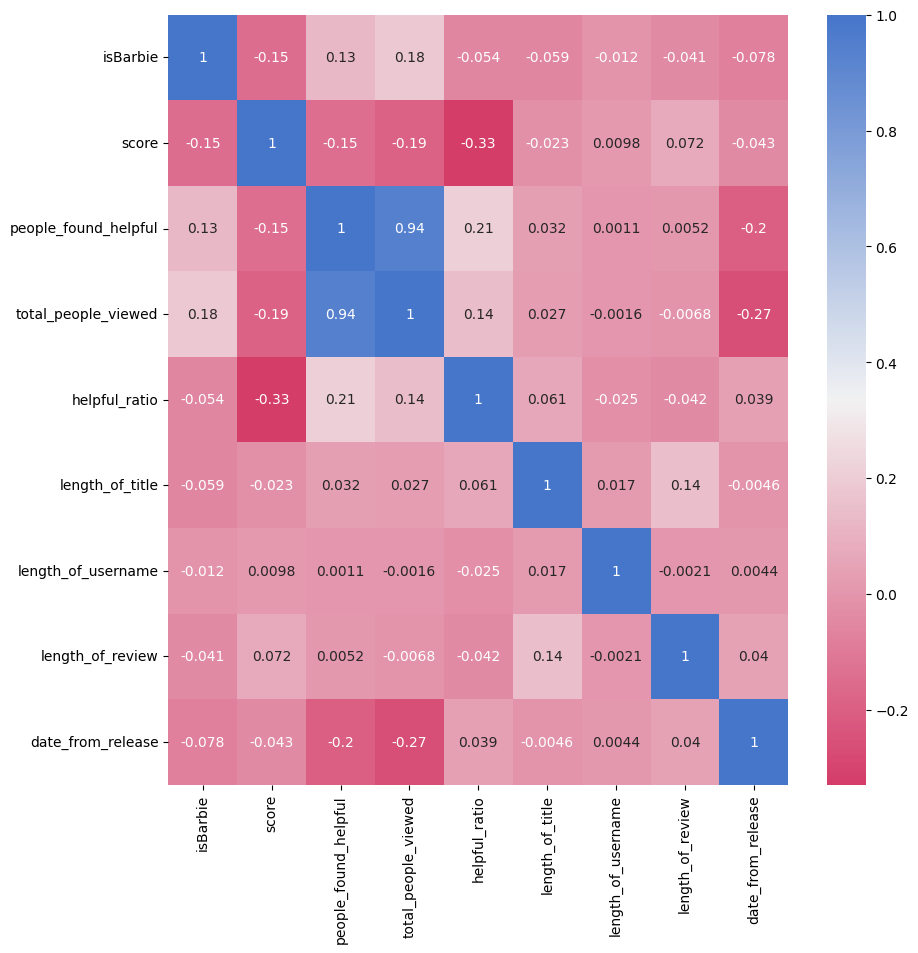

In [8]:
# Coorelation Matrix
import matplotlib.pyplot as plt
import seaborn as sns

drop_na_df = numeric_df[numeric_df['score'] != 'NULL']

fig1 = plt.figure(figsize=(10, 10))
ax1 = fig1.add_subplot(111)

cmap = sns.diverging_palette(0, 255, n=256, as_cmap=True)

sns.heatmap(data=drop_na_df.corr(), ax=ax1, cmap=cmap, annot=True)

plt.show()

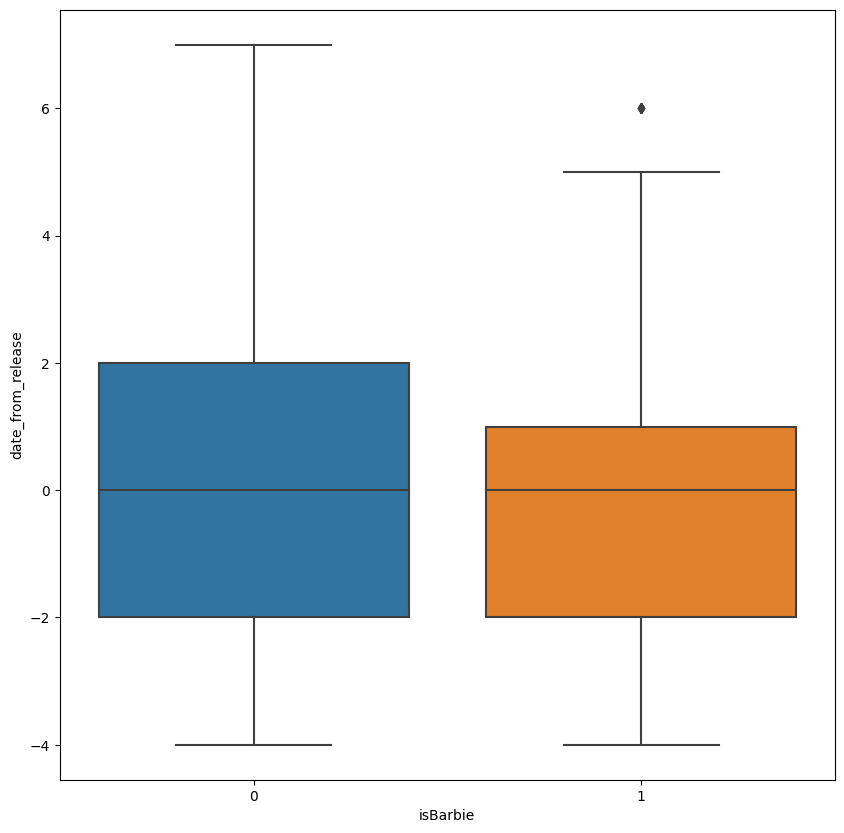

In [9]:
fig2 = plt.figure(figsize=(10, 10))
ax2 = fig2.add_subplot(111)

sns.boxplot(data=numeric_df, x='isBarbie', y='date_from_release', ax=ax2)

plt.show()

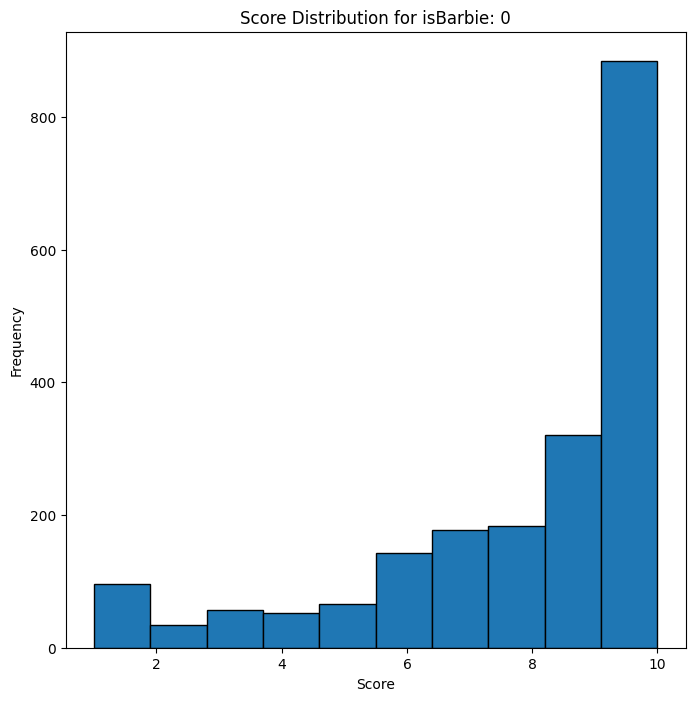

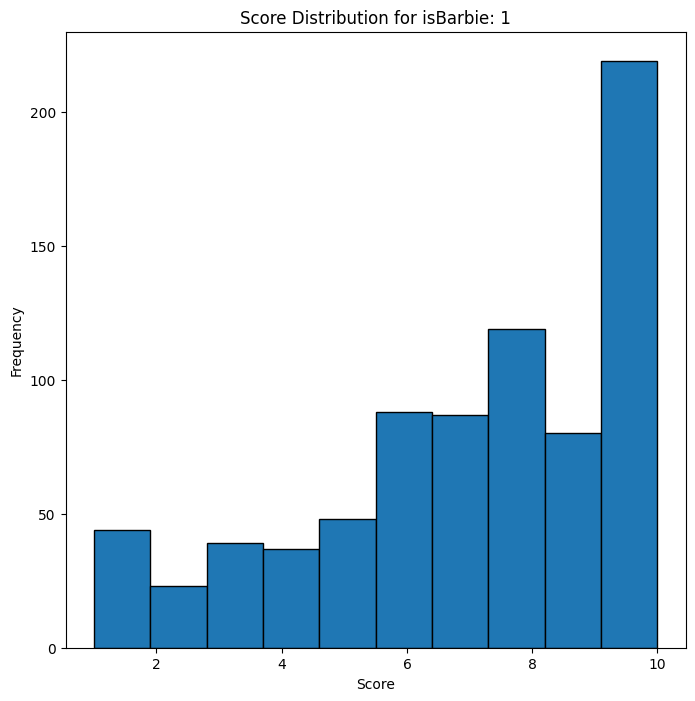

In [10]:
group_by = df.groupby('isBarbie')
for movie_id, group_data in group_by:
    plt.figure(figsize=(8, 8))
    plt.hist(group_data['score'], edgecolor='black')
    plt.title(f'Score Distribution for isBarbie: {movie_id}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

## Modeling

In [11]:
def get_bert_data(dff):
    return dff[['review', 'isBarbie']].copy()


def get_BoW_data(dff):
    from sklearn.feature_extraction.text import CountVectorizer
    BoW_text_data = dff[['review', 'isBarbie']].copy()

    reviews = BoW_text_data['review']
    vectorizer = CountVectorizer()

    X = vectorizer.fit_transform(reviews)
    BoW_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([dff['isBarbie'], BoW_df], axis=1)


def get_ANN_data(dff):
    opp_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Oppenheimer'] + count['oppenheimer']
        opp_inst.append(amount)

    # Calculates the number of instances the word "Barbie" was used
    barbie_inst = []

    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Barbie'] + count['barbie']
        barbie_inst.append(amount)

    # Calculates the number of instances the word "movie" was used
    movie_inst = []

    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Movie'] + count['movie']
        movie_inst.append(amount)

    # Calculates the number of instances the word "war" was used
    war_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['War'] + count['war']
        war_inst.append(amount)

    # Calculates the number of instances the word "woman" was used
    woman_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Woman'] + count['woman'] + count['Women'] + count['women']
        woman_inst.append(amount)

    # Calculates the number of instances the actress Margot Robbie from Barbie was mentioned
    margot_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Margot'] + count['margot'] + count['Robbie'] + count['robbie']
        margot_inst.append(amount)

    # Calculates the number of instances the actor Ryan Gosling or Ken from Barbie was mentioned
    ken_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Ryan'] + count['ryan'] + count['Gosling'] + count['gosling'] + count['Ken'] + count['ken']
        ken_inst.append(amount)

    # Calculates the number of instances the actress Emily Blunt or Kitty from Oppenheimer was mentioned
    kitty_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Emily'] + count['emily'] + count['Blunt'] + count['blunt'] + count['Kitty'] + count['kitty']
        kitty_inst.append(amount)

    # Calculates the number of instances the actor Cillian Murphy from Oppenheimer was mentioned
    cillian_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Cillian'] + count['cillian'] + count['Murphy'] + count['murphy']
        cillian_inst.append(amount)

    # Calculates the number of instances an exclamation mark was used
    excl_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i])
        amount = count['!']
        excl_inst.append(amount)

    new_df = pd.DataFrame()
    new_df['opp_inst'] = opp_inst
    new_df['barbie_inst'] = barbie_inst
    new_df['movie_inst'] = movie_inst
    new_df['war_inst'] = war_inst
    new_df['woman_inst'] = woman_inst
    new_df['margot_inst'] = margot_inst
    new_df['ken_inst'] = ken_inst
    new_df['cillian_inst'] = cillian_inst
    new_df['kitty_inst'] = kitty_inst
    new_df['excl_inst'] = excl_inst
    new_df['score'] = numeric_df['score']
    new_df['date_from_release'] = numeric_df['date_from_release']
    new_df['isBarbie'] = numeric_df['isBarbie']
    return new_df.sample(frac=1)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = df.sample(frac=1, random_state=42)

train, test = train_test_split(df, test_size=0.2, shuffle=False)

Bert_train = get_bert_data(train)
Bert_X_train = Bert_train.drop(columns='isBarbie')
Bert_y_train = Bert_train['isBarbie']
Bert_test = get_bert_data(test)
Bert_X_test = Bert_test.drop(columns='isBarbie')
Bert_y_test = Bert_test['isBarbie']

BoW_df = get_BoW_data(df)

BoW_train, BoW_test = train_test_split(BoW_df, test_size=0.2, shuffle=False)
# Index order is kept but index is discarded in extraction
BoW_X_train = BoW_train.drop(columns='isBarbie')
BoW_y_train = BoW_train['isBarbie']
BoW_X_test = BoW_test.drop(columns='isBarbie')
BoW_y_test = BoW_test['isBarbie']

ANN_df = get_ANN_data(df)

ANN_train, ANN_test = train_test_split(ANN_df, test_size=0.2, shuffle=False)
ANN_X_train = ANN_train.drop(columns='isBarbie')
ANN_y_train = ANN_train['isBarbie']
ANN_X_test = ANN_test.drop(columns='isBarbie')
ANN_y_test = ANN_test['isBarbie']

normalize = MinMaxScaler()
ANN_X_train = normalize.fit_transform(ANN_X_train)
ANN_X_test = normalize.transform(ANN_X_test)


### BERT

In [13]:
# def get_bert_data():
#     return df[['review', 'title', 'isBarbie']].copy()
#
# bert_text_data = get_bert_data()

In [14]:
from sklearn.model_selection import train_test_split

# Bert_X_train, Bert_X_test, Bert_y_train, Bert_y_test = train_test_split(bert_text_data.drop(columns = ['isBarbie', 'title']), bert_text_data['isBarbie'], stratify=bert_text_data['isBarbie'], test_size = 0.2, random_state = 42)
# Bert_X_train, Bert_X_test, Bert_y_train, Bert_y_test = train_test_split(bert_text_data.drop(columns = ['isBarbie', 'title']), bert_text_data['isBarbie'], test_size = 0.2, random_state = 42)


In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [20]:
from keras.layers import Dense, Input
from keras.optimizers import Adam

# BERT layers
text_input = Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = Dense(1, activation='sigmoid')(l)

# Use inputs and outputs to construct a final model
bert_model = tf.keras.Model(inputs=[text_input], outputs = [l])

bert_model.compile(optimizer = Adam(learning_rate = 0.2), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [21]:
# bert_history = bert_model.fit(Bert_X_train, Bert_y_train, batch_size = 512, epochs = 1)

In [22]:


from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras.layers import Dropout


bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

<ipython-input-22-0881c39cb17c>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [23]:
# !pip install keras-tuner


In [24]:
# pip install tensorflow_text


In [25]:


text_input = Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = Dense(1, activation='sigmoid')(l)

bert_model = tf.keras.Model(inputs=[text_input], outputs = [l])

bert_model.compile(optimizer = Adam(learning_rate = 0.2), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:

def build_bert_model(hp):
    text_input = Input(shape=(), dtype=tf.string)
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    l = Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1), name="dropout")(outputs['pooled_output'])
    l = Dense(hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu')(l)
    l = Dense(1, activation='sigmoid')(l)

    model = tf.keras.Model(inputs=[text_input], outputs=[l])

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = RandomSearch(
    build_bert_model,
    objective='val_accuracy',
    max_trials=2,
    directory='my_dir',
    project_name='my_project'
)

tuner.search(Bert_X_train, Bert_y_train, epochs=3, validation_data=(Bert_X_test, Bert_y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print("Learning Rate:", best_hps.get('learning_rate'))
print("Dropout Rate:", best_hps.get('dropout_rate'))
print("Dense Units:", best_hps.get('dense_units'))

best_bert_model = build_bert_model(best_hps)

best_bert_model.fit(Bert_X_train, Bert_y_train, batch_size=32, epochs=500)

test_accuracy = best_bert_model.evaluate(Bert_X_test, Bert_y_test, verbose=0)[1]
print("Test Accuracy:", test_accuracy)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.5               |0.5               |dropout_rate
16                |16                |dense_units
0.01              |0.01              |learning_rate

Epoch 1/3
 5/70 [=>............................] - ETA: 18:27 - loss: 0.9906 - accuracy: 0.5312

### Bag of Words

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
#
# def get_BoW_data():
#     BoW_text_data = df[['review', 'isBarbie']].copy()
#
#     reviews = BoW_text_data['review']
#     vectorizer = CountVectorizer()
#
#     X = vectorizer.fit_transform(reviews)
#     BoW_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
#     return pd.concat([BoW_df, BoW_text_data['isBarbie']], axis=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# BoW_df = get_BoW_data()
#
# BoW_X_train, BoW_X_test, BoW_y_train, BoW_y_test = train_test_split(BoW_df.drop(columns='isBarbie'), BoW_df['isBarbie'], test_size=0.2, random_state=42)

BoW_decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# BoW_decision_tree.fit(BoW_X_train, BoW_y_train)

### ANN

In [ ]:
# def get_ANN_data():
#     from collections import Counter
#     opp_inst = []
#     for i in range(len(df['review'])):
#         count = Counter(df['review'][i].split())
#         amount = count['Oppenheimer'] + count['oppenheimer']
#         opp_inst.append(amount)
#
#     barbie_inst = []
#     for i in range(len(df['review'])):
#         count = Counter(df['review'][i].split())
#         amount = count['Barbie'] + count['barbie']
#         barbie_inst.append(amount)
#
#     movie_inst = []
#     for i in range(len(df['review'])):
#         count = Counter(df['review'][i].split())
#         amount = count['Movie'] + count['movie']
#         movie_inst.append(amount)
#
#     excl_inst = []
#     from collections import Counter
#     for i in range(len(df['review'])):
#         count = Counter(df['review'][i])
#         amount = count['!']
#         excl_inst.append(amount)
#
#     new_df = pd.DataFrame()
#     new_df['opp_inst'] = opp_inst
#     new_df['barbie_inst'] = barbie_inst
#     new_df['movie_inst'] = movie_inst
#     new_df['excl_inst'] = excl_inst
#     new_df['score'] = numeric_df['score']
#     new_df['date_from_release'] = numeric_df['date_from_release']
#     new_df['isBarbie'] = numeric_df['isBarbie']
#     return new_df.sample(frac=1)

In [ ]:
# ANN_Data = get_ANN_data()
# ANN_X_train, ANN_X_test, ANN_y_train, ANN_y_test = train_test_split(ANN_Data.drop(columns='isBarbie'),ANN_Data['isBarbie'], test_size=0.2, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

ANN = Sequential()

ANN.add(Dense(units=16, activation='sigmoid', input_shape=(ANN_X_train.shape[1],)))
ANN.add(Dense(units=8, activation='sigmoid'))
ANN.add(Dense(units=4, activation='sigmoid'))
ANN.add(Dense(units=1, activation='sigmoid'))

opt = Adam(learning_rate=1e-03)

ANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# ANN_history = ANN.fit(ANN_X_train, ANN_y_train, epochs=100, batch_size=16)

## Training

In [ ]:
Bert_X_train.shape
# Bert_y_train.shape

In [ ]:
bert_history = bert_model.fit(Bert_X_train, Bert_y_train, batch_size = 512, epochs = 1)

In [ ]:
BoW_decision_tree.fit(BoW_X_train, BoW_y_train)

In [ ]:
ANN_history = ANN.fit(ANN_X_train, ANN_y_train, epochs=60, batch_size=32, validation_data=(ANN_X_test, ANN_y_test))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ANN_history.history['loss'], label = "Training Loss")
plt.plot(ANN_history.history['val_loss'], label = "Validation Loss")
plt.legend()

### Customized Ensemble

In [ ]:
# print(Bert_y_test.head())
# print(BoW_y_test.head())
# print(ANN_y_test.head())

In [ ]:
bert_train_yhat = bert_model.predict(Bert_X_train)
BoW_train_yhat = BoW_decision_tree.predict(BoW_X_train).reshape(BoW_X_train.shape[0], 1)
ANN_train_yhat = ANN.predict(ANN_X_train)

In [ ]:
from sklearn.metrics import classification_report

bert_train_yhat = [1 if yhat > 0.5 else 0 for yhat in bert_train_yhat]
BoW_train_yhat = [1 if yhat > 0.5 else 0 for yhat in BoW_train_yhat]
ANN_train_yhat = [1 if yhat > 0.5 else 0 for yhat in ANN_train_yhat]

print('BERT Train')
print(classification_report(bert_train_yhat, Bert_y_train))
print('========================================')
print('BoW Train')
print(classification_report(BoW_train_yhat, BoW_y_train))
print('========================================')
print('ANN Train')
print(classification_report(ANN_train_yhat, ANN_y_train))

In [ ]:
bert_test_yhat = bert_model.predict(Bert_X_test)
BoW_test_yhat = BoW_decision_tree.predict(BoW_X_test)
ANN_test_yhat = ANN.predict(ANN_X_test)

In [ ]:
bert_test_yhat = [1 if yhat > 0.5 else 0 for yhat in bert_test_yhat]
BoW_test_yhat = [1 if yhat > 0.5 else 0 for yhat in BoW_test_yhat]
ANN_test_yhat = [1 if yhat > 0.5 else 0 for yhat in ANN_test_yhat]

print('BERT Test')
print(classification_report(bert_test_yhat, Bert_y_test))
print('========================================')
print('BoW Test')
print(classification_report(BoW_test_yhat, BoW_y_test))
print('========================================')
print('ANN Test')
print(classification_report(ANN_test_yhat, ANN_y_test))

In [ ]:
ensemble_X_train = pd.concat([pd.DataFrame(bert_train_yhat), pd.DataFrame(BoW_train_yhat), pd.DataFrame(ANN_train_yhat)], axis=1)
# ensemble_X_train = pd.concat([pd.DataFrame(BoW_train_yhat), pd.DataFrame(ANN_train_yhat)], axis=1)
ensemble_y_train = train['isBarbie']

ensemble_X_test = pd.concat([pd.DataFrame(bert_test_yhat), pd.DataFrame(BoW_test_yhat), pd.DataFrame(ANN_test_yhat)], axis=1)

# ensemble_X_test = pd.concat([pd.DataFrame(bert_model.predict(Bert_X_test)), pd.DataFrame(BoW_decision_tree.predict(BoW_X_test).reshape(BoW_X_test.shape[0], 1)), pd.DataFrame(ANN.predict(ANN_X_test))], axis=1)
ensemble_y_test = test['isBarbie']

In [ ]:
ensemble_model = Sequential()

ensemble_model.add(Dense(units=3, activation='sigmoid', input_shape=(ensemble_X_train.shape[1],)))
ensemble_model.add(Dense(units=1, activation='sigmoid'))

opt = Adam(learning_rate=1e-04)

ensemble_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
ensemble_history = ensemble_model.fit(ensemble_X_train, ensemble_y_train, epochs=50, batch_size=8, validation_data=(ensemble_X_test, ensemble_y_test))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ensemble_history.history['loss'], label = "Training Loss")
plt.plot(ensemble_history.history['val_loss'], label = "Validation Loss")
plt.legend()

In [ ]:
ensemble_yhat = ensemble_model.predict(ensemble_X_test)

ensemble_yhat = [1 if yhat > 0.5 else 0 for yhat in ensemble_yhat]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ensemble_yhat, ensemble_y_test))

In [ ]:
# Simple vote
ensemble_X_test = pd.concat([pd.DataFrame(BoW_test_yhat), pd.DataFrame(ANN_test_yhat)], axis=1)
ensemble_yhat = ensemble_X_test.sum(axis=1)
ensemble_yhat = [1 if yhat > 1 else 0 for yhat in ensemble_yhat]

print(classification_report(ensemble_yhat, ensemble_y_test))